In [58]:
import os

import scipy as sp
import numpy as np
import pandas as pd
import sklearn as sk
import networkx as nx

from matplotlib import pyplot as plt
from learning_dist_metrics import ldm

%matplotlib inline

In [5]:
user_df = pd.read_csv("data/drhuang_person.csv", header=0)
friend_df = pd.read_csv("data/drhuang_friend.csv", header=0,)

## split data by column
uid_df = user_df["ID"]
profile_df = user_df[[c for c in user_df.columns if c != "ID"]]

In [12]:
friend_df.head(3)
#friend_df.columns = [""range(0, friend_df.shape[1]-1)
relation_mtx = friend_df.ix[:, 1:]
relation_mtx.head(4)

friend_pairs = []
uid_row = friend_df.ix[:, 0]
uid_col = uid_row

# convert relationship matrix into a list of user pairs
# to represent friendships, iterating through items
# on the lower triangle of the matrix
for i, uid_a in enumerate(uid_row):
    for j, uid_b in enumerate(uid_col):

        if uid_a < uid_b:
            ind = relation_mtx.ix[i, j]
            if ind == 1:
                friend_pairs.append((uid_a, uid_b))

# load relationship into networkx.Graph()
from networkx import Graph

fnx = Graph()
fnx.add_edges_from(friend_pairs)

In [61]:
def scalar(x):
    _min, _max = min(x), max(x)
    _range = (_max - _min) * 1.0
    res = [(i - _min) / _range for i in x]
    return res

## transform data
new_profile_df = pd.DataFrame()

new_profile_df["ID"]        = uid_df #uid_df["ID"]
new_profile_df["Gender"]    = profile_df.ix[:, 0]
new_profile_df["Age"]       = scalar(profile_df["Age"])
new_profile_df["Region"]    = scalar(profile_df["Region"])
new_profile_df["Education"] = scalar(profile_df["Education"])
new_profile_df["Income"]    = scalar(profile_df["Income"])
new_profile_df["Hobby"]     = scalar(profile_df["Hobby"])
new_profile_df["Duration"]  = scalar(profile_df["Duration"])

In [236]:
import scipy as sp
import numpy as np
import pandas as pd

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph
from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean


def user_grouped_dist(user_id, weights, profile_df, friends_networkx):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

    Parameters:
    ----------
    * user_id: {integer}, the target user's ID
    * weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    * friends_networkx: {networkx.Graph()}, Graph() object from Networkx
        to store the relationships informat
    Returns:
    -------
    res: {list, list of integers}, a list of two lists, which store the distances
        of either friends and non-friends separately.

    Examples:
    ---------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[ ["ID"] + cols ]
    user_dist = user_grouped_dist(user_id = 0, weights = weights
        , profile_df, friends_df)
    print user_dist["friends"]
    print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    # get the user_id of friends of the target user
    friends_ls = friends_networkx.neighbors(user_id)
    all_ids = profile_df.ID
    non_friends_ls = [u for u in all_ids if u not in friends_ls + [user_id]]

    sim_dist_vec = []
    for f_id in friends_ls:
        friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)

    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=False, _n=100):
						 
    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    # is_valid = (len(sim_dist_vec) >= min_nobs) & \
    #           (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1], _n)

        # ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]
		
    return res


def users_filter_by_weights(weights, profile_df, friends_networkx,
                            pval_threshold=0.5,
                            mutate_rate=0.4,
                            min_friend_cnt=10,
                            users_list=None,
                            fit_rayleigh=False,
                            _n=1000,
                            is_debug=False):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

    Parameters:
    ----------
    weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    pval_threshold: {float}, the threshold for p-value to reject hypothesis
    min_friend_cnt: {integer}, drop users whose total of friends is less than
       this minimum count
    mutate_rate: {float}, a float value [0 - 1] determine the percentage of
       bad_fits member sent to mutation
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution
    is_debug: {boolean}, to control if it yeilds by-product information

    Returns:
    -------
    res: {list} grouped list of user ids
        res[0] stores all users whose null hypothesis does not holds;
        res[1] stores all users whose null hypothesis hold null hypothesis,
        given weights, distance distribution of all friends is significantly
        different from distance distribution of all non-friends

    Examples:
    --------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[["ID"] + cols]
    grouped_users = users_filter_by_weights(weights,
                       profile_df, friends_df, pval_threshold = 0.10,
                       min_friend_cnt = 10)

    Notes:
    -----
    min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    if users_list is None:
        users_list = list(profile_df.ix[:, 0])

    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_networkx)
        pval = user_dist_kstest(res_dists[0], res_dists[1], fit_rayleigh, _n)
        pvals.append(pval)

    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])

    if is_debug:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]
        good_pvals = [p for i, p in sorted_id_pval if p < pval_threshold]
        bad_pvals = [p for i, p in sorted_id_pval if p >= pval_threshold]
    else:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]

    if len(bad_fits) > 0:
        mutate_size = np.ceil(len(bad_fits) * mutate_rate)
        mutate_size = max(int(mutate_size), 1)
        id_retain = good_fits + bad_fits[mutate_size:]
        id_mutate = bad_fits[:mutate_size]
        # split pval
        if is_debug:
            # if len(good_pvals) > 0:
            # if len(bad_pvals) > 0:  
            pval_retain = good_pvals + bad_pvals[mutate_size:]
            pval_mutate = bad_pvals[:mutate_size]
    else:
        id_retain = good_fits
        id_mutate = bad_fits

        if is_debug:
            
            if len(good_pvals) > 0:
                pval_retain = good_pvals 
            else: 
                pval_retain = []
                
            if len(bad_pvals) > 0:
                pval_mutate = bad_pvals
            else:
                pval_mutate = []

    if is_debug:
        res = [id_retain, id_mutate, pval_retain, pval_mutate]
    else:
        res = [id_retain, id_mutate]

    return res


def ldm_train_with_list(users_list, profile_df, friends, retain_type=1):
    """ learning distance matrics with ldm() instance, provided with selected
        list of users.

    Parameters:
    -----------
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends: {list of tuple}, each tuple keeps a pair of user id
    retain_type: {integer}, 0, adopting 'or' logic by keeping relationship in
        friends_df if either of entities is in user_list 1, adopting 'and'
        logic

    Returns:
    -------
    res: {vector-like, float}, output of ldm.get_transform_matrix()

    Examples:
    ---------
    new_dist_metrics = ldm_train_with_list(user_list, profile_df, friends_df)
    """
    if retain_type == 0:
        friends = [(a, b) for a, b in friends if \
            a in users_list or b in users_list]
    else:
        friends = [(a, b) for a, b in friends if \
            a in users_list and b in users_list]
    
    ldm = LDM()    
    ldm.fit(profile_df, friends)
    weight_vec = ldm.get_transform_matrix()
    return weight_vec     


def hyper_parameter_tester(weights_a, weights_b, fit_rayleigh, num):
    
    """
    """
    
    num_friends = []
    num_nonfriends = []
    ks_pvals_right = []
    ks_pvals_wrong = []

    for uid in tg0_ids: 
        # Compare the distribution of a user's distances of all of his/her friends
        # against the distribuiton of a users's distances of all of his/her non-friends,
        # The collection of non-friends may include those users of two categories with
        # respect to their relationships to the target user: 
        # a. the users who are not likened by the target users 
        # b. the users who are likely to be befriended by the users however
        #    the users do not have a change to be exposed to her/him.
        sim_dists, diff_dists = user_grouped_dist(uid, weights_a, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_right.append(pval)
    
        sim_dists, diff_dists = user_grouped_dist(uid, weights_b, profile_df, fnx)
        pval = user_dist_kstest(sim_dists, diff_dists, fit_rayleigh=fit_rayleigh, _n = num)
        ks_pvals_wrong.append(pval)
    
        num_friends.append(len(sim_dists))
        num_nonfriends.append(len(diff_dists))
    
    res_report = pd.DataFrame({"ID": tg0_ids, 
		                       "num_friends": num_friends, 
                               "num_nonfriends": num_nonfriends, 
                               "true_pval": ks_pvals_right,
                               "wrong_pval": ks_pvals_wrong})
							   
    return res_report

In [66]:
all_uids = user_df["ID"].unique()

w = ldm_train_with_list(all_uids, new_profile_df, friend_pairs, retain_type=1)

--- 26.0992388725 seconds ---


In [67]:
import cProfile, pstats, StringIO

pr = cProfile.Profile()
pr.enable()
print "Profiler start analyzing ... "

ldm = LDM()
ldm.fit(new_profile_df, friend_pairs)

pr.disable()
print "Profiler stop here ... "


--- 32.6142828465 seconds ---


In [68]:
s = StringIO.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

         34811825 function calls (34811821 primitive calls) in 33.963 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   33.963   11.321 /home/beingzy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3005(run_code)
        1    0.000    0.000   33.963   33.963 <ipython-input-67-f6fe47afd699>:7(<module>)
        1    0.000    0.000   33.963   33.963 learning_dist_metrics/ldm.py:48(fit)
        1    0.003    0.003   33.963   33.963 learning_dist_metrics/ldm.py:88(_fit)
      185    0.002    0.000   32.790    0.177 learning_dist_metrics/ldm.py:134(objective_func)
      370    0.532    0.001   32.768    0.089 learning_dist_metrics/dist_metrics.py:62(all_pairwise_dist)
        1    0.000    0.000   32.614   32.614 /home/beingzy/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37(minimize)
        1    0.001    0.001   32.614   32.614 /home/beingzy/anaconda/lib/pyt

### Algorithm Optimization

* collect pvalue of each iteration
* collect the group assign
* start with 2 container strategy

In [ ]:
# {"id": {"group": [0, 0, 0, 1], "pval": [0.2, 0.1, 0.3, 0.8]}}
user_pvals = {}
user

In [109]:
# summary of characteristics 
# 1. two container - swapping strategy
# 2. decreasing threshold (min. = 0.2)

# input variables:
profile_df = new_profile_df
friends_networkx = fnx
friends_df = friend_pairs
users_list = all_uids

# learning parameter
RETAIN_TYPE = 0
PVAL = 0.5
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 30
mutate_rate = 1
# process controller
counter = 0

# performance collector
num_good_fits = []
num_bad_fits = []
g0_dist_weights = []
g1_dist_weights = []
g0_size = []
g1_size = []
user_learning_details = {} # dictionary {"uid":{"group":[], "pval":[]}}


# -------- Initial Weights Leanring ----------- #
ldm = LDM()
ldm.fit(profile_df, friends_df)
the_dist_weights = ldm.get_transform_matrix()

g0, g1 = users_filter_by_weights(weights=the_dist_weights, 
                                 profile_df=profile_df, 
                                 friends_networkx=friends_networkx, 
                                 pval_threshold=PVAL, 
                                 mutate_rate=0.5, 
                                 min_friend_cnt=10, 
                                 users_list=users_list, 
                                 is_debug=False)

print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1))

# -------- Individual Group Learning ----------- #
thresholds = np.linspace(PVAL, 0.2, max_iters)

while counter < max_iters:
    
    # decreasing threshold
    threshold = thresholds[counter]
    
    counter += 1
    #mutate_rate = min(mutate_rate + 0.05, 1)
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    
    g0_good, g0_bad, pval0_good, pval0_bad = users_filter_by_weights(weights=g0_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=threshold, 
                                              mutate_rate=0.2, 
                                              min_friend_cnt=10, 
                                              users_list=g0, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    g1_good, g1_bad, pval1_good, pval1_bad = users_filter_by_weights(weights=g1_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=threshold, 
                                              mutate_rate=0.2, 
                                              min_friend_cnt=10, 
                                              users_list=g1, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    
    if len(pval0_good) > 0 or len(pval1_good) > 0:
        g0_pvals = pval0_good + pval1_bad
        g1_pvals = pval0_bad + pval1_good
        
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    
    g0_dist_weights.append(g0_dist)
    g1_dist_weights.append(g1_dist)
    num_good_fits.append(len(g0_good) + len(g1_good))
    num_bad_fits.append(len(g0_bad) + len(g1_bad))
    g0_size.append(len(g0))
    g1_size.append(len(g1))
    
    ## collect learning details
    group_id = 0
    for u, p in zip(g0, g0_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]
        
    group_id = 1
    for u, p in zip(g1, g1_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]

--- 27.4557380676 seconds ---
# of memebers in group 0: 50, # of memebers in group 1: 50
------- 1 iteration --------
--- 32.3719489574 seconds ---
--- 25.0569279194 seconds ---
Group 0's learned distance metrics:
[0.0, 0.12, 0.0, 0.4, 0.0, 0.47, 0.0]
Group 1's learned distance metrics:
[0.0, 0.23, 0.0, 0.29, 0.0, 0.48, 0.0]
---------------------------------------------- 
# of good fits: 44, # of bad fits: 6
# of good fits: 44, # of bad fits: 6
---------------------------------------------- 
# of memebers in group 0: 50, # of memebers in group 1: 50
*********************************************** 

------- 2 iteration --------
--- 20.3033790588 seconds ---
--- 34.6221408844 seconds ---
Group 0's learned distance metrics:
[0.0, 0.11, 0.0, 0.4, 0.0, 0.49, 0.0]
Group 1's learned distance metrics:
[0.0, 0.22, 0.0, 0.33, 0.0, 0.46, 0.0]
---------------------------------------------- 
# of good fits: 45, # of bad fits: 5
# of good fits: 45, # of bad fits: 5
----------------------------------

## Learning Module

In [171]:
_ncol = 1 + len(user_learning_details[1]["group"])
_nrow = len(user_learning_details.keys())

exp01_user_group_df = pd.DataFrame(np.zeros((_nrow, _ncol)))
exp01_user_pval_df = pd.DataFrame(np.zeros((_nrow, _ncol)))
exp01_user_group_df.columns = ["ID"] + ["loop_" + str(i) for i in range(1, _ncol)]
exp01_user_pval_df.columns = ["ID"] + ["loop_" + str(i) for i in range(1, _ncol)]

exp01_user_group_df["ID"] = user_learning_details.keys()
exp01_user_pval_df["ID"] = exp01_user_group_df["ID"]

for i, uid in enumerate(user_learning_details.keys()):
    
    exp01_user_group_df.ix[i, 1:] = user_learning_details[uid]["group"]
    exp01_user_pval_df.ix[i, 1:] = user_learning_details[uid]["pval"]

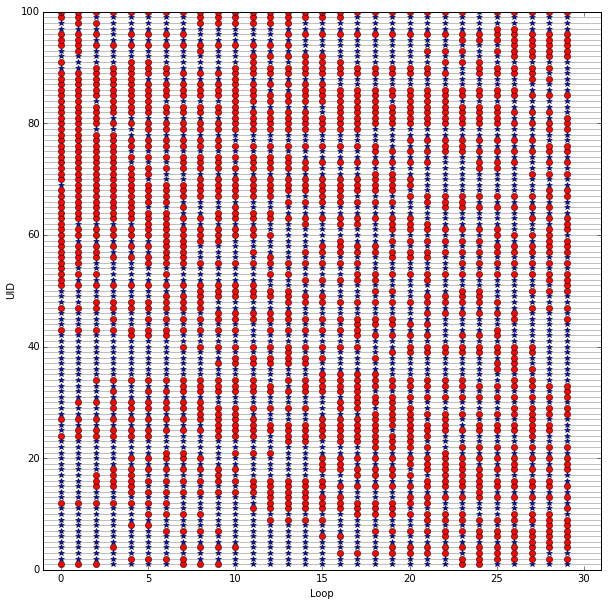

In [186]:
plt.figure(figsize=(10, 10))

loop_cols = ["loop_" + str(i) for i in range(1, _ncol)]

for i, uid in enumerate(user_group_df["ID"]):
    
    plt.axhline(y=uid, linewidth=1, c="grey", alpha=.5)
    
    for j, l in enumerate(loop_cols, 0):
        
        _group = user_group_df.ix[i, l]
        
        if _group == 0:
            plt.plot(j, uid, "ro")
        else:
            plt.plot(j, uid, "b*")
            
    

plt.xlim([-1, len(loop_cols) + 1])
#plt.ylim([-1, ])
plt.xlabel("Loop")
plt.ylabel("UID")
#plt.legend(["ro", "b+"], ["Group 0", "Group 1"])
plt.show()

In [237]:
# summary of characteristics 
# 1. two container - swapping strategy
# 2. decreasing threshold (min. = 0.2)

# high initial split pvalue
# 100% mutate rate

# input variables:
profile_df = new_profile_df
friends_networkx = fnx
friends_df = friend_pairs
users_list = all_uids

# learning parameter
RETAIN_TYPE = 0
PVAL = 0.5
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 30
mutate_rate = 1
# process controller
counter = 0

# performance collector
num_good_fits = []
num_bad_fits = []
g0_dist_weights = []
g1_dist_weights = []
g0_size = []
g1_size = []
user_learning_details = {} # dictionary {"uid":{"group":[], "pval":[]}}


# -------- Initial Weights Leanring ----------- #
ldm = LDM()
ldm.fit(profile_df, friends_df)
the_dist_weights = ldm.get_transform_matrix()

g0, g1 = users_filter_by_weights(weights=the_dist_weights, 
                                 profile_df=profile_df, 
                                 friends_networkx=friends_networkx, 
                                 pval_threshold=0.8, 
                                 mutate_rate=mutate_rate, 
                                 min_friend_cnt=10, 
                                 users_list=users_list, 
                                 is_debug=False)

print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1))

# -------- Individual Group Learning ----------- #
thresholds = np.linspace(PVAL, 0.2, max_iters)

while counter < max_iters:
    
    # decreasing threshold
    threshold = thresholds[counter]
    
    counter += 1
    #mutate_rate = min(mutate_rate + 0.05, 1)
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    
    g0_good, g0_bad, pval0_good, pval0_bad = users_filter_by_weights(weights=g0_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=threshold, 
                                              mutate_rate=mutate_rate, 
                                              min_friend_cnt=10, 
                                              users_list=g0, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    g1_good, g1_bad, pval1_good, pval1_bad = users_filter_by_weights(weights=g1_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=threshold, 
                                              mutate_rate=mutate_rate, 
                                              min_friend_cnt=10, 
                                              users_list=g1, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    
    if len(pval0_good) > 0 or len(pval1_good) > 0:
        g0_pvals = pval0_good + pval1_bad
        g1_pvals = pval0_bad + pval1_good
        
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    
    g0_dist_weights.append(g0_dist)
    g1_dist_weights.append(g1_dist)
    num_good_fits.append(len(g0_good) + len(g1_good))
    num_bad_fits.append(len(g0_bad) + len(g1_bad))
    g0_size.append(len(g0))
    g1_size.append(len(g1))
    
    ## collect learning details
    group_id = 0
    for u, p in zip(g0, g0_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]
        
    group_id = 1
    for u, p in zip(g1, g1_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]

--- 26.4789130688 seconds ---
# of memebers in group 0: 0, # of memebers in group 1: 100
------- 1 iteration --------
--- 29.4298629761 seconds ---
--- 26.9867479801 seconds ---
Group 0's learned distance metrics:
[0.25, 0.08, 0.25, 0.08, 0.18, 0.07, 0.09]
Group 1's learned distance metrics:
[0.0, 0.14, 0.0, 0.35, 0.0, 0.51, 0.0]
---------------------------------------------- 
# of good fits: 0, # of bad fits: 0
# of good fits: 48, # of bad fits: 52
---------------------------------------------- 
# of memebers in group 0: 52, # of memebers in group 1: 48
*********************************************** 

------- 2 iteration --------
--- 21.3279099464 seconds ---
--- 34.2738919258 seconds ---
Group 0's learned distance metrics:
[0.0, 0.16, 0.0, 0.37, 0.0, 0.47, 0.0]
Group 1's learned distance metrics:
[0.0, 0.1, 0.0, 0.37, 0.0, 0.53, 0.0]
---------------------------------------------- 
# of good fits: 27, # of bad fits: 25
# of good fits: 25, # of bad fits: 23
---------------------------

In [238]:
_ncol = 1 + len(user_learning_details[1]["group"])
_nrow = len(user_learning_details.keys())

exp02_user_group_df = pd.DataFrame(np.zeros((_nrow, _ncol)))
exp02_user_pval_df = pd.DataFrame(np.zeros((_nrow, _ncol)))
exp02_user_group_df.columns = ["ID"] + ["loop_" + str(i) for i in range(1, _ncol)]
exp02_user_pval_df.columns = ["ID"] + ["loop_" + str(i) for i in range(1, _ncol)]

exp02_user_group_df["ID"] = user_learning_details.keys()
exp02_user_pval_df["ID"] = exp02_user_group_df["ID"]

for i, uid in enumerate(user_learning_details.keys()):
    
    exp02_user_group_df.ix[i, 1:] = user_learning_details[uid]["group"]
    exp02_user_pval_df.ix[i, 1:] = user_learning_details[uid]["pval"]

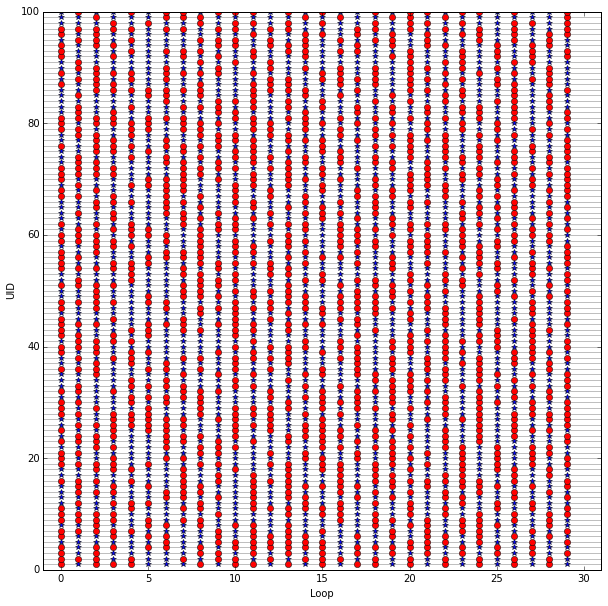

In [241]:
plt.figure(figsize=(10, 10))

loop_cols = ["loop_" + str(i) for i in range(1, _ncol)]

for i, uid in enumerate(user_group_df["ID"]):
    
    plt.axhline(y=uid, linewidth=1, c="grey", alpha=.5)
    
    for j, l in enumerate(loop_cols, 0):
        
        _group = exp02_user_group_df.ix[i, l]
        
        if _group == 0:
            plt.plot(j, uid, "ro")
        else:
            plt.plot(j, uid, "b*")

plt.xlim([-1, len(loop_cols) + 1])
#plt.ylim([-1, ])
plt.xlabel("Loop")
plt.ylabel("UID")
#plt.legend(["ro", "b+"], ["Group 0", "Group 1"])
plt.show()

#good: 48, #bad: 3


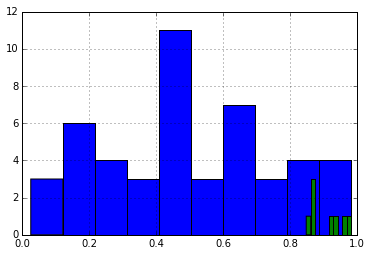

In [178]:
# summary of characteristics 
# 1. two container - swapping strategy
# 2. decreasing threshold (min. = 0.2)

# algorithm characteristics
# * high initial split pvalue
# * 100% mutate rate
# * high-pval in container b

# input variables:
profile_df = new_profile_df
friends_networkx = fnx
friends_df = friend_pairs
users_list = all_uids

# learning parameter
RETAIN_TYPE = 0
PVAL = 0.5
MIN_FRIENDS = 10 # not implemented in function
# hyper-parameter
max_iters = 30
mutate_rate = 1
# process controller
counter = 0

# performance collector
num_good_fits = []
num_bad_fits = []
g0_dist_weights = []
g1_dist_weights = []
g0_size = []
g1_size = []
user_learning_details = {} # dictionary {"uid":{"group":[], "pval":[]}}


# -------- Initial Weights Leanring ----------- #
ldm = LDM()
ldm.fit(profile_df, friends_df)
the_dist_weights = ldm.get_transform_matrix()

g0, g1 = users_filter_by_weights(weights=the_dist_weights, 
                                 profile_df=profile_df, 
                                 friends_networkx=friends_networkx, 
                                 pval_threshold=0.8, 
                                 mutate_rate=mutate_rate, 
                                 min_friend_cnt=10, 
                                 users_list=users_list, 
                                 is_debug=False)

print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1))

# -------- Individual Group Learning ----------- #
thresholds = np.linspace(PVAL, 0.2, max_iters)

while counter < max_iters:
    
    # decreasing threshold
    threshold = thresholds[counter]
    
    counter += 1
    #mutate_rate = min(mutate_rate + 0.05, 1)
    print "------- %d iteration --------" % counter
    g0_dist = ldm_train_with_list(g0, profile_df, friends_df, retain_type=RETAIN_TYPE)
    g1_dist = ldm_train_with_list(g1, profile_df, friends_df, retain_type=RETAIN_TYPE)
    
    print "Group 0's learned distance metrics:"
    print g0_dist
    print "Group 1's learned distance metrics:"
    print g1_dist

    print "---------------------------------------------- "
    
    g0_good, g0_bad, pval0_good, pval0_bad = users_filter_by_weights(weights=g0_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=threshold, 
                                              mutate_rate=mutate_rate, 
                                              min_friend_cnt=10, 
                                              users_list=g0, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    g1_good, g1_bad, pval1_good, pval1_bad = users_filter_by_weights(weights=g1_dist, 
                                              profile_df=profile_df, 
                                              friends_networkx=friends_networkx, 
                                              pval_threshold=0.9, 
                                              mutate_rate=mutate_rate, 
                                              min_friend_cnt=10, 
                                              users_list=g1, 
                                              fit_rayleigh=True, 
                                              _n=5000,
                                              is_debug=True)
    
    
    print "# of good fits: %d, # of bad fits: %d" % (len(g0_good), len(g0_bad))
    print "# of good fits: %d, # of bad fits: %d" % (len(g1_good), len(g1_bad))

    print "---------------------------------------------- "
    g0 = g0_good + g1_bad
    g1 = g0_bad + g1_good
    
    if len(pval0_good) > 0 or len(pval1_good) > 0:
        g0_pvals = pval0_good + pval1_bad
        g1_pvals = pval0_bad + pval1_good
        
    print "# of memebers in group 0: %d, # of memebers in group 1: %d" % (len(g0), len(g1)) 
    print "*********************************************** \n"
    
    g0_dist_weights.append(g0_dist)
    g1_dist_weights.append(g1_dist)
    num_good_fits.append(len(g0_good) + len(g1_good))
    num_bad_fits.append(len(g0_bad) + len(g1_bad))
    g0_size.append(len(g0))
    g1_size.append(len(g1))
    
    ## collect learning details
    group_id = 0
    for u, p in zip(g0, g0_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]
        
    group_id = 1
    for u, p in zip(g1, g1_pvals):
        if u in user_learning_details:
            user_learning_details[u]["group"] = user_learning_details[u]["group"] + [group_id]
            user_learning_details[u]["pval"] = user_learning_details[u]["pval"] + [p]
        else:
            user_learning_details[u] = {}
            user_learning_details[u]["group"] = [group_id]
            user_learning_details[u]["pval"] = [p]